In [22]:
from dataset import load_dataset

batches, person_list, input_shape = load_dataset()

In [5]:
import os
import numpy as np
import mobilenetv2
import facenet
import gc
from itertools import combinations
from sklearn.utils import shuffle
from facenet import triplet_loss, accuracy
from utils import relative_path

ModuleNotFoundError: No module named 'mobilenetv2'

In [3]:
EPOCHS = 32
EMBEDDING_SIZE = 128
MAX_TRIPLET_LIST_SIZE = 300
SEMIHARD_MARGIN = 0.2

def load_model(batches, input_shape):
    base_model = mobilenetv2.create_model(input_shape, EMBEDDING_SIZE)
    facenet_model = facenet.create_model(base_model, input_shape, EMBEDDING_SIZE)
    facenet_model.compile(optimizer='adam',
                          loss=triplet_loss,
                          metrics=[accuracy])
    return facenet_model, base_model

# facenet_model, base_model = load_model(batches, input_shape)

In [31]:
def is_semihard(anchor, pos, neg):
    return np.linalg.norm(anchor - pos) + SEMIHARD_MARGIN > np.linalg.norm(anchor - neg)


def get_semihards(batch, embeddings, anchor_i, pos_i, person_target):
    semihards = []
    for i, person in enumerate(batch['y']):
        neg = batch['X'][i]
        if person != person_target and is_semihard(embeddings[anchor_i], embeddings[pos_i], embeddings[i]):
            semihards.append(neg)
    return np.array(semihards)


def get_positives(batch, person_target):
    pos_indices = []
    for i, person in enumerate(batch['y']):
        if person == person_target:
            pos_indices.append(i)
    return np.array(pos_indices)


def get_triplets(batch, embeddings, person_list):
    triplets = [[], [], []]
    for person in person_list:
        pos_indices = get_positives(batch, person)
        pos_tuples = list(combinations(pos_indices, 2))
        for anchor_i, pos_i in pos_tuples:
            semihards = get_semihards(batch, embeddings, anchor_i, pos_i, person)
            for semihard in semihards:
                triplets[0].append(batch['X'][anchor_i])
                triplets[1].append(batch['X'][pos_i])
                triplets[2].append(semihard)
    return [np.array(triplets[0]), np.array(triplets[1]), np.array(triplets[2])]

In [ ]:
batch = batches[0]
embeddings = model.predict(batch['X'])
triplets = get_triplets(batch, embeddings, person_list)

In [11]:
input_shape

(100, 75, 1)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def showImage(img):
    plt.imshow(img.reshape((100, 75)), cmap='gray', vmin=0, vmax=1)
    plt.show()

In [111]:
anchor, pos, neg = shuffle(triplets[0], triplets[1], triplets[2])

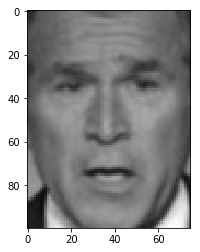

In [142]:
showImage(anchor[60])

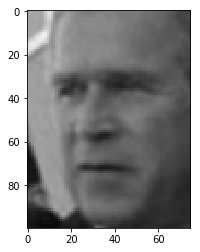

In [143]:
showImage(pos[60])

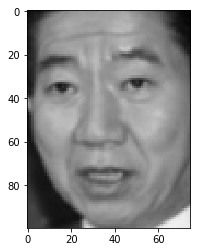

In [144]:
showImage(neg[60])

In [80]:
def train(siamese_model, base_model, batches, person_list):
    for epoch in range(EPOCHS):
        print('-- EPOCH: %s' % (epoch + 1))
        for i, batch in enumerate(batches):
            print('Training batch %s out of %s' % (i + 1, len(batches)))
            embeddings = base_model.predict(batch['X'])
            triplets = get_triplets(batch, embeddings, person_list)

            for i in range(0, len(triplets[0]), MAX_TRIPLET_LIST_SIZE):
                triplet_sublist = [triplets[0][i:i+MAX_TRIPLET_LIST_SIZE], triplets[1][i:i+MAX_TRIPLET_LIST_SIZE], triplets[2][i:i+MAX_TRIPLET_LIST_SIZE]]
                yield triplet_sublist
                
        base_model.save_weights(MODEL_SAVE_PATH + 'facenet_squeezenet_weights.h5')

In [81]:
it = train(facenet_model, base_model, batches, person_list)

In [82]:
cec = next(it)

-- EPOCH: 1
Training batch 1 out of 7


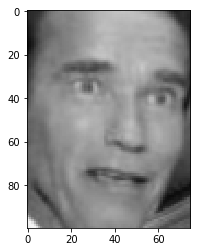

In [85]:
showImage(cec[2][1])

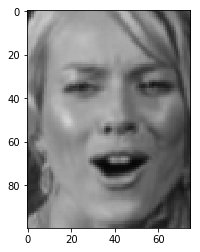

In [79]:
showImage(triplets[2][500])

In [5]:
from squeezenet import create_model

model = create_model((100, 75, 1), 128)

In [6]:
model.load_weights('../model/facenet_squeezenet_weights.h5')

In [7]:
import numpy as np

count = 0

for i in range(0, 200):
    a = model.predict(triplets[0][i].reshape((1, 100, 75, 1)))
    b = model.predict(triplets[1][i].reshape((1, 100, 75, 1)))
    c = model.predict(triplets[2][i].reshape((1, 100, 75, 1)))
    if np.linalg.norm(a-b) + 0.2 > np.linalg.norm(a-c):
        count += 1
        
count

NameError: name 'triplets' is not defined

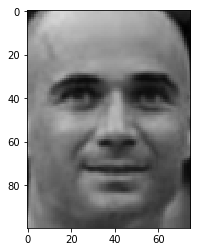

In [13]:
showImage(batches[0]['X'][26])

In [188]:
len(person_list)

57

In [244]:
pos_tuples = list(combinations(pos, 2))
len(pos_tuples)

1

In [248]:
anchor, pos = pos_tuples[0]
semihards = get_semihards(batch, embeddings, anchor, pos, person)
len(semihards)

64

In [14]:
a = model.predict(batches[1]['X'][25].reshape((1, 100, 75, 1)))
b = model.predict(batches[0]['X'][26].reshape((1, 100, 75, 1)))
np.linalg.norm(a-b)

2.1790984

In [265]:
is_semihard(anchor, pos, semihards[30])

True

In [271]:
cecek = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
cecek[[1, 4]]

array([2, 5])

In [16]:
from sklearn.datasets import fetch_lfw_people

lfw_people = fetch_lfw_people(min_faces_per_person=1, resize=0.8)
lfw_people.images.shape

(13233, 100, 75)